In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\python\ML\pothole_detection_CNN\Datasets',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\DCL\AppData\Local\Temp\ipykernel_5200\3882198774.py:2: SyntaxWarning: invalid escape sequence '\p'
  'E:\python\ML\pothole_detection_CNN\Datasets',


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

48

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 0 0 2 0 0 2 1 1 0 2 0 2 1 1 0 0 0 2 2 2 2 0 2 0 1 0 2 0 1 2]


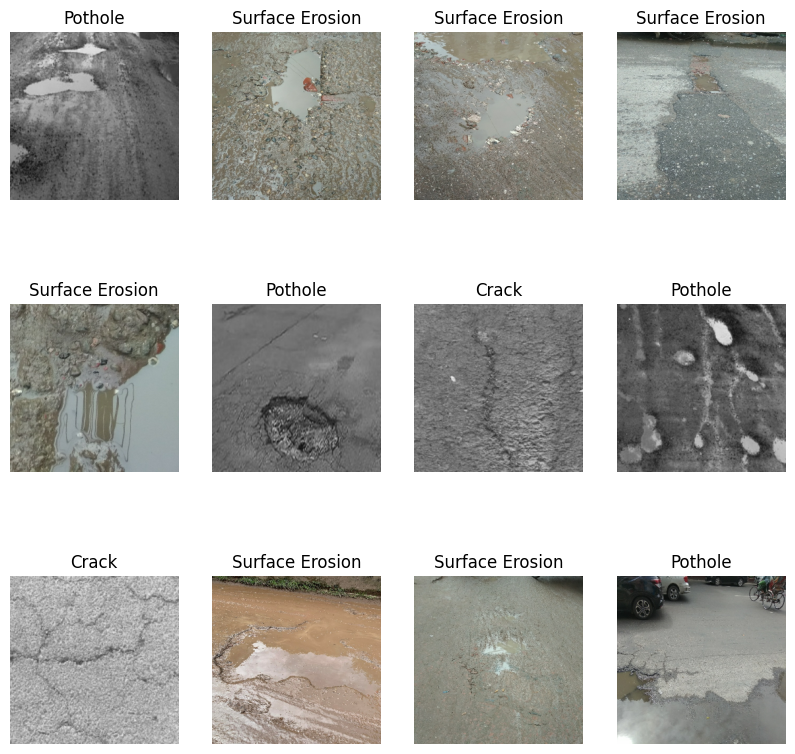

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
train_size = 0.8
len(dataset)*train_size

38.400000000000006

In [9]:
train_data = dataset.take(38)
len(train_data)

38

In [10]:
test_data = dataset.skip(38)
len(test_data)

10

In [11]:
validation_size = 0.1
len(dataset)*validation_size

4.800000000000001

In [12]:
validation_data  = test_data.take(4)
len(validation_data)

4

In [13]:
test_data = test_data.skip(4)
len(test_data)

6

In [14]:
# Dataset split function
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds


In [15]:
train_data, validation_data, test_data = get_dataset_partition(dataset)

In [16]:
len(train_data)
len(validation_data)
len(test_data)

6

In [17]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [20]:
def build_resnet50_model():
    base = tf.keras.applications.ResNet50(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [21]:
model = build_resnet50_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 50s 1us/step


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.3786 - loss: 1.2420 - val_accuracy: 0.3197 - val_loss: 1.0437
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.4384 - loss: 1.0565 - val_accuracy: 0.4344 - val_loss: 1.0235
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.4814 - loss: 1.0298 - val_accuracy: 0.5164 - val_loss: 0.9655
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.4916 - loss: 1.0056 - val_accuracy: 0.5656 - val_loss: 0.9538
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.5261 - loss: 0.9720 - val_accuracy: 0.5574 - val_loss: 0.9322
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.5099 - loss: 0.9819 - val_accuracy: 0.5656 - val_loss: 0.9344
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.4753 - loss: 1.0077 - val_accuracy: 0.5000 - val_loss: 0.9502
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.5310 - loss: 0.9593 - val_accuracy: 0.4098 - val_lo

In [25]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5574 - loss: 0.9007


[0.900119960308075, 0.5572916865348816]

In [26]:
model.save("Trained Model/RESNET.h5")

In [27]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 38}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
history.history['accuracy']

[0.3900826573371887,
 0.44214877486228943,
 0.48677685856819153,
 0.4809917211532593,
 0.5115702748298645,
 0.515702486038208,
 0.5041322112083435,
 0.5074380040168762,
 0.5049586892127991,
 0.5264462828636169,
 0.5247933864593506,
 0.5148760080337524,
 0.5173553824424744,
 0.5223140716552734,
 0.5123966932296753,
 0.5214875936508179,
 0.5256198644638062,
 0.5338842868804932,
 0.5446280837059021,
 0.5297520756721497,
 0.5297520756721497,
 0.5322313904762268,
 0.531404972076416,
 0.5223140716552734,
 0.5297520756721497,
 0.5148760080337524,
 0.5438016653060913,
 0.5264462828636169,
 0.5305784940719604,
 0.5446280837059021,
 0.5322313904762268,
 0.539669394493103,
 0.5338842868804932,
 0.539669394493103,
 0.542148768901825,
 0.5413222908973694,
 0.5388429760932922,
 0.547107458114624,
 0.542148768901825,
 0.5347107648849487,
 0.5446280837059021,
 0.5454545617103577,
 0.542148768901825,
 0.5380165576934814,
 0.5256198644638062,
 0.5322313904762268,
 0.5504132509231567,
 0.5429751873016357

In [30]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
F1 Score (macro): 0.43452260968890677
F1 Score (weighted): 0.4519596603507357

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.00      0.00      0.00        60
        Pothole       0.70      0.58      0.63        45
Surface Erosion       0.52      0.93      0.67        87

       accuracy                           0.56       192
      macro avg       0.41      0.50      0.43       192
   weighted avg       0.40      0.56      0.45       192



e:\python\ML\pothole_detection_CNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\python\ML\pothole_detection_CNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\python\ML\pothole_detection_CNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

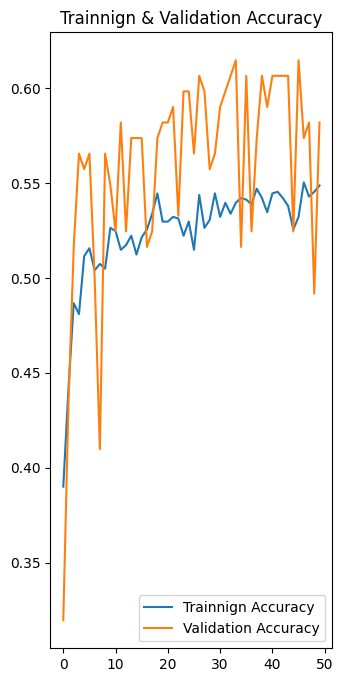

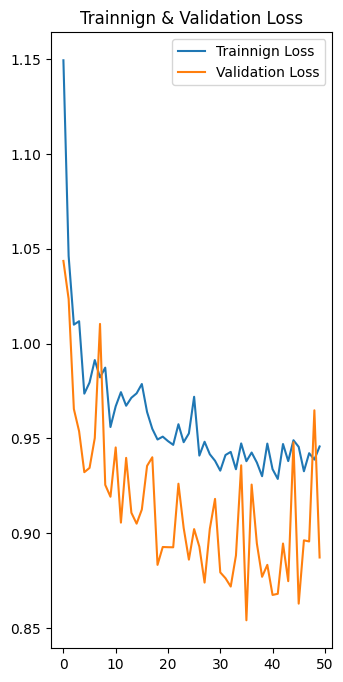

In [32]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [33]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5750 - loss: 0.8753


[0.9001198410987854, 0.5572916865348816]

First image to predict
First image actual label:  Surface Erosion
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label:  Surface Erosion


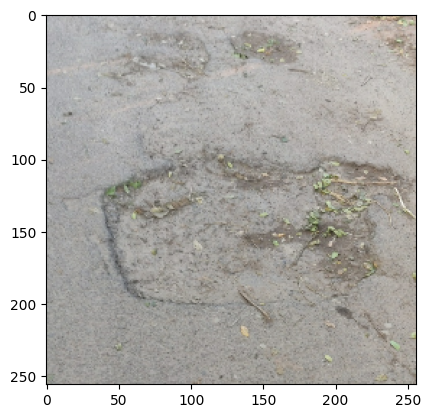

In [34]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->51.380001068115234 Light:-> Normal lighting
Confidence:->52.630001068115234 Light:-> Normal lighting
Confidence:->50.880001068115234 Light:-> Normal lighting
Confidence:->41.36000061035156 Light:-> Normal lighting
Confidence:->52.630001068115234 Light:-> Normal lighting
Confidence:->40.75 Light:-> Normal lighting
Confidence:->92.95999908447266 Light:-> Normal lighting
Confidence:->51.91999816894531 Light:-> Normal lighting
Confidence:->89.97000122070312 Light:-> Normal lighting


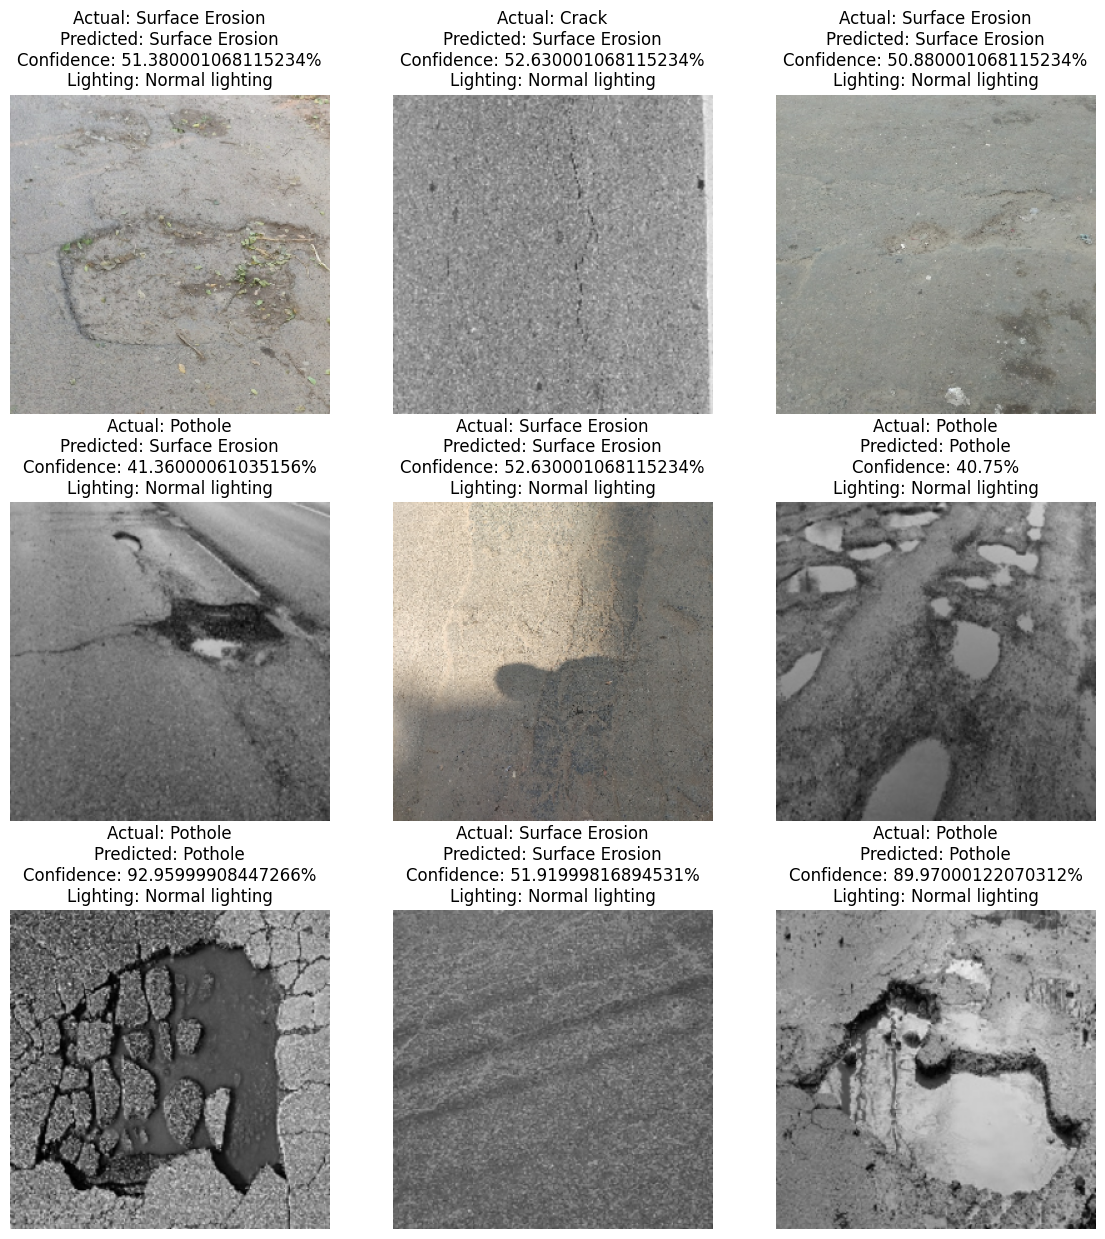

In [36]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [37]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Pothole, Confidence: 89.97000122070312


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


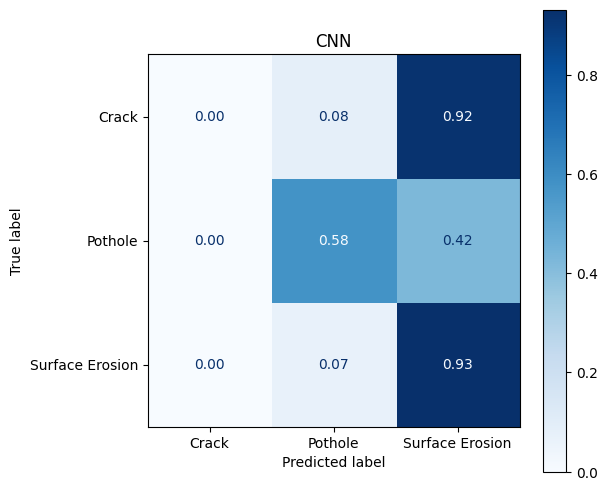

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)

    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("CNN")
plt.savefig("confusion_matrix_resnet.png", dpi=300, bbox_inches='tight')
plt.show()
